In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, roc_auc_score, recall_score, precision_score, make_scorer
from imblearn.over_sampling import SMOTE

In [2]:
# load data
X_train = np.load(f'../weka/data/conc/X_train_con.npy', allow_pickle=True)
y_train = np.load(f'../weka/data/conc/y_train_con.npy')
X_test = np.load(f'../weka/data/conc/X_test_con.npy', allow_pickle=True)
y_test = np.load(f'../weka/data/conc/y_test_con.npy')
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (526,)
y_train shape: (526,)
X_test shape: (140,)
y_test shape: (140,)


In [3]:
# count how many 0 and 1 in y_train and y_test
unique, counts = np.unique(y_train, return_counts=True)
print(f'y_train counts: {dict(zip(unique, counts))}')

unique, counts = np.unique(y_test, return_counts=True)
print(f'y_test counts: {dict(zip(unique, counts))}')

y_train counts: {0: 174, 1: 352}
y_test counts: {0: 70, 1: 70}


In [3]:
X_train = pd.DataFrame.from_records(X_train.flatten())
X_test = pd.DataFrame.from_records(X_test.flatten())

print(X_train.head(1))

          pc0         pc1        pc2  rising_waveform  falling_waveform  \
0 -1145.10333 -184.335831  44.555012         1.008289          0.595026   

   peak_temperature  cultivar  
0        272.237944         3  


In [4]:
# normalize data
scaler = StandardScaler()
features = X_train.columns
X_train[features] = scaler.fit_transform(X_train[features])
X_test[features] = pd.DataFrame(scaler.transform(X_test[features]), columns=features)

print(X_train.head(1))

        pc0       pc1       pc2  rising_waveform  falling_waveform  \
0 -0.292195 -1.162778  0.450848        -0.342958         -0.361642   

   peak_temperature  cultivar  
0         -0.342958       0.0  


In [5]:
# Define your model
model = LogisticRegression(class_weight='balanced', random_state=42)

# Define the search spaces
search_spaces = {
    'C': Real(0.001, 100, prior='log-uniform'),
    'solver': Categorical(['newton-cg', 'lbfgs', 'liblinear'])
}

# Instantiate the BayesSearchCV object
bayes_search = BayesSearchCV(
    estimator=model,
    search_spaces=search_spaces,
    scoring='roc_auc',
    n_iter=50,  # Number of iterations; adjust based on computational resources
    cv=5,  # You can specify more specific cross-validation strategy if needed
    n_jobs=-1,
    verbose=2,
    random_state=42
)

# Fit the model
bayes_search.fit(X_train, y_train)

print(f'Best parameters: {bayes_search.best_params_}')

# Using the best model from bayes search to predict on test data
y_pred = bayes_search.predict(X_test)

# Evaluation (you can add more metrics as needed)
print(f"Test Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Test F1 Score: {f1_score(y_test, y_pred)}")
print(f"Test Precision: {precision_score(y_test, y_pred)}")
print(f"Test Recall: {recall_score(y_test, y_pred)}")
print(f"Test ROC AUC Score: {roc_auc_score(y_test, y_pred)}")

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

In [6]:
def run_model(X_train, y_train, X_test, y_test):
    # Apply SMOTE to training data
    # smote = SMOTE(sampling_strategy='minority', random_state=42)
    # X_train, y_train = smote.fit_resample(X_train, y_train)

    # Initialize Logistic Regression model with balanced class weights
    model = LogisticRegression(class_weight='balanced', random_state=42)

    # Perform 5-fold cross-validation with stratified splits
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    scoring = { 'accuracy': make_scorer(accuracy_score), 'precision': make_scorer(precision_score), 'recall': make_scorer(recall_score), 'f1': make_scorer(f1_score), 'roc_auc': make_scorer(roc_auc_score)}
    cv_scores = cross_validate(model, X_train, y_train, cv=skf, scoring=scoring)

    # Fit the model
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Calculate the accuracy and F1 score
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, y_pred)

    # Print the results
    print(f"Accuracy: {accuracy}")
    print(f"F1 Score: {f1}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"AUC-ROC: {auc_roc}")
    print('------------------------------------')
    print(f"Cross-Validation Accuracy Scores: {cv_scores['test_accuracy'].mean()}")
    print(f"Cross-Validation F1 Scores: {cv_scores['test_f1'].mean()}")
    print(f"Cross-Validation Precision Scores: {cv_scores['test_precision'].mean()}")
    print(f"Cross-Validation Recall Scores: {cv_scores['test_recall'].mean()}")
    print(f"Cross-Validation ROC-AUC Scores: {cv_scores['test_roc_auc'].mean()}")

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Dead", "Alive"])
    plt.figure(figsize=(6, 6))
    disp.plot(cmap="Blues")
    plt.show()

    feature_importances = np.abs(model.coef_[0])  # Absolute values of coefficients
    plt.figure(figsize=(8, 6))
    plt.barh(X_train.columns, feature_importances)
    plt.xlabel('Feature Importance')
    plt.show()

    # ROC curve
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Compute ROC curve and AUC score
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line (random chance)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

Logistic Regression for Con-Data without tunning
Accuracy: 0.6285714285714286
F1 Score: 0.6338028169014085
Precision: 0.625
Recall: 0.6428571428571429
AUC-ROC: 0.6285714285714286
------------------------------------
Cross-Validation Accuracy Scores: 0.7376406926406927
Cross-Validation F1 Scores: 0.7978500927178259
Cross-Validation Precision Scores: 0.8248276435416049
Cross-Validation Recall Scores: 0.775484089043411
Cross-Validation ROC-AUC Scores: 0.7182018146366481


<Figure size 600x600 with 0 Axes>

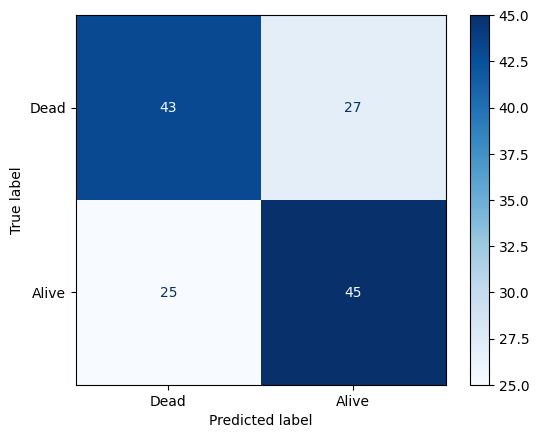

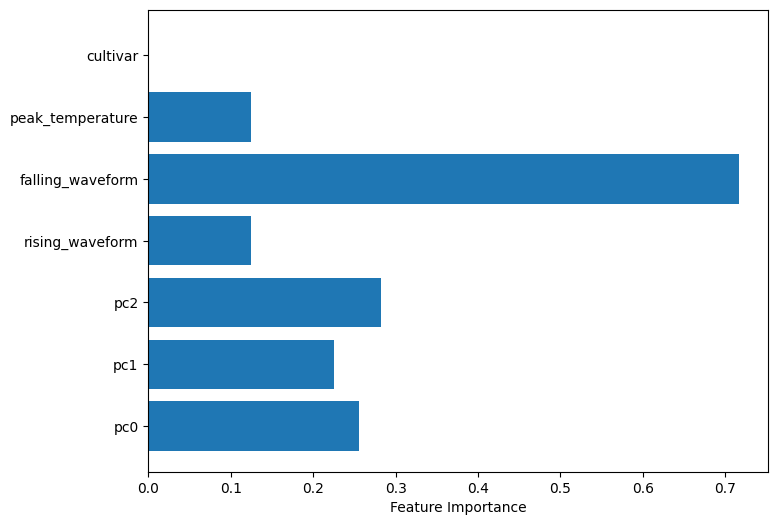

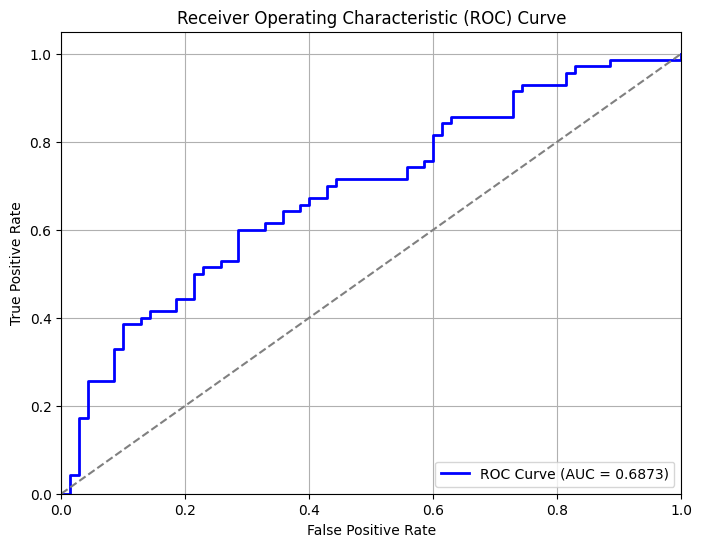

In [7]:
print('Logistic Regression for Con-Data without tunning')
run_model(X_train, y_train, X_test, y_test)

Accuracy: 0.6285714285714286
F1 Score: 0.6338028169014085
Precision: 0.625
Recall: 0.6428571428571429
AUC-ROC: 0.6285714285714286
------------------------------------
Cross-Validation Accuracy Scores: 0.7376406926406927
Cross-Validation F1 Scores: 0.7978500927178259
Cross-Validation Precision Scores: 0.8248276435416049
Cross-Validation Recall Scores: 0.775484089043411
Cross-Validation ROC-AUC Scores: 0.7182018146366481


<Figure size 600x600 with 0 Axes>

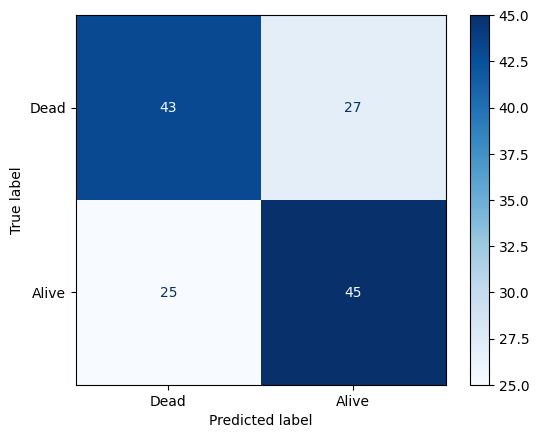

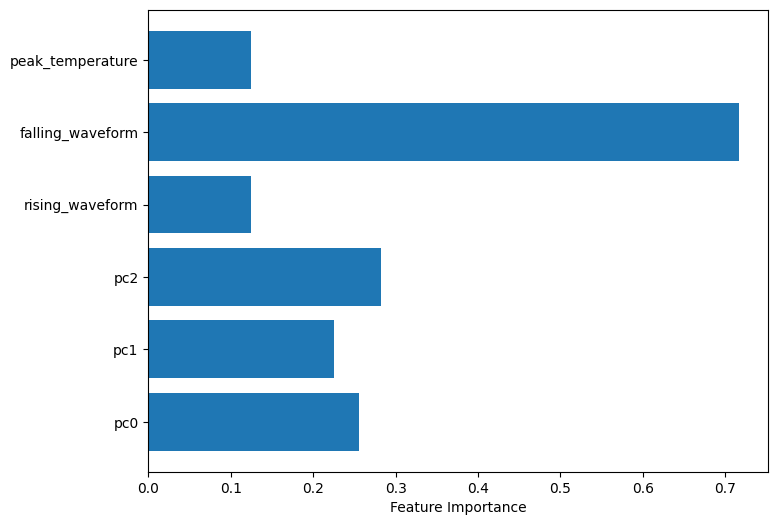

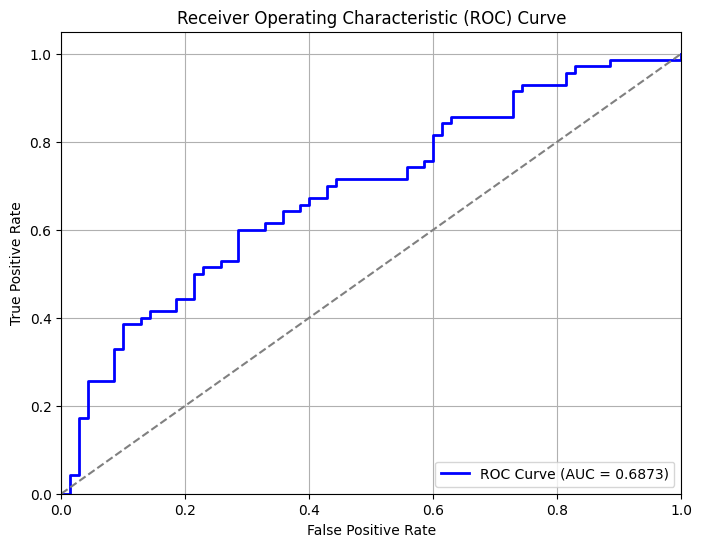

In [8]:
# throw the cultivar feature away and run the model again
X_train = X_train.drop(columns=['cultivar'])
X_test = X_test.drop(columns=['cultivar'])
run_model(X_train, y_train, X_test, y_test)

In [9]:
# Create a DataFrame for storing ROC data
# roc_df = pd.DataFrame({"FPR": fpr, "TPR": tpr})
# roc_df["Model"] = "Logistic Regression"  # Label for the model
# roc_df["AUC"] = roc_auc  # Store AUC score as a column

# Save to CSV (appending if file exists)
# roc_df.to_csv("roc_comparison.csv", mode='a', index=False, header=not pd.io.common.file_exists("roc_comparison.csv"))